This notebook is to test different ansatz for VarQITE algorithm. We are using the VarQITE algorithm to find the eigenvalues of a Tight Binding Hamiltonian. We are currently testing an ansatz which creates superposition of states of a particular sub_space (such that number of ones in all the superposed states is same). We then expect this ansatz to give the lowest eigenvalue of that sub-space.  

For Example, for a 5 qubit system it would look like this :  

$$|{\psi \rangle = a_0| 10001\rangle + a_1|10010 \rangle + a_2|10100 \rangle + a_3| 11000\rangle + a_4|01001 \rangle + a_5| 01010\rangle + a_6| 01100\rangle + a_7|00101 \rangle + a_8| 00110\rangle + a_9|00011 \rangle }$$  

for number of ones = 2 or  

$$| \psi \rangle = a_0|10000 \rangle + a_1|01000 \rangle + a_2| 00100\rangle + a_3| 00010\rangle + a_4| 00001 \rangle$$   
for number of ones = 1  
- Run this notebook for different ansatz (currently : su2, easy, easy3)

In [20]:
import numpy as np
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp, Statevector
from tabulate import tabulate
from itertools import combinations
from qiskit.circuit.library import EfficientSU2
import math
import time
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple
from qiskit.algorithms import TimeEvolutionProblem
from qiskit.algorithms import VarQITE
from qiskit.primitives import Estimator
from qiskit.quantum_info import Statevector
from qiskit.algorithms import SciPyImaginaryEvolver
import pylab
from qiskit.algorithms.gradients import ReverseEstimatorGradient, ReverseQGT
from qiskit.circuit.library import RYGate, RZGate
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

import os
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from scipy.linalg import eigh, block_diag

In [21]:
def spinless_sub_dim(N,r) : 
    '''
    input : number of lattice sites (N), number of electrons (r) 
    output : dimension of this subspace 
    '''
    return math.comb(N,r)

def hubb0_model(N,r,e,t,U): 
    ''' Generalised Tight Binding (spinless) model for periodic boundary condition
    Input : Number of lattice sites (int), number of electrons(int), hopping constant (int/float), onsite energies (list), interaction term U (int)
    Output : Tight binding Hamiltonian, eigenvalues and eigenvectors of the matrix ''' 
    dim = spinless_sub_dim(N,r)
    #Special Cases
    if r==0 : 
        H = np.zeros(1)
        eigval = 0
        new_vec = [[1]]
    elif r==N : 
        H = [[sum(e)+N*U]]
        eigval = H[0]
        new_vec = [[1]]
    if N == 1 and r==1: 
        H = [e]
        eigval = H[0]
        new_vec = [[1]]
    else : 
        H = np.zeros((dim, dim))
        basis_set = spinless_basis(N,r)
        #H_diagonal, onsite energy terms
        n_diag = np.zeros(dim)
        for i in range(dim) : 
            for j in range(N) : 
                n_diag[i] += e[j]*basis_set[i][j]
        np.fill_diagonal(H,n_diag)
        #H_T Hopping terms 
        for basis_index,basis in enumerate(basis_set) : 
            for site in range(len(basis)) : 
                if basis[site] == False and basis[(site+1)%N] == True : 
                    new_state = basis.copy()
                    new_state[site] = True
                    new_state[(site+1)%N] = False 
                    for i in range(len(basis_set)) : 
                        if basis_set[i] == new_state: 
                            f_index = i
                    H[f_index][basis_index] +=t
                if N != 2 : 
                    if basis[site] == True and basis[(site+1)%N] == False : 
                        new_state = basis.copy()
                        new_state[site] = False
                        new_state[(site+1)%N] = True 
                        for i in range(len(basis_set)) : 
                            if basis_set[i] == new_state : 
                                f_index = i
                        H[f_index][basis_index] +=t 
        #H_U, interaction terms
        for basis_index,basis in enumerate(basis_set) : 
            for site in range(len(basis)) : 
                if basis[site] == True and basis[(site+1)%N] == True : 
                    H[basis_index][basis_index] +=U

        eigval,eigvec = np.linalg.eigh(H)
        new_vec = list(zip(*eigvec))                   
    return H,eigval,new_vec

def hubb0_full(N,e,t,U): 
    '''Full Block Diagonal Hamiltonian for some N length closed lattice '''
    H_sub_list = []
    for r in range(N+1) : 
        H_sub = hubb0_model(N,r,e,t,U)[0]
        H_sub_list.append(H_sub)
    H = block_diag(*H_sub_list) 
    return H

#JW functions
def hubb0_JW(N,e,t,U) : 
    strings = []
    opt = SparsePauliOp.from_sparse_list([("I", [0], 0)], num_qubits=N)  
    for k in range(N) : 
        a0='I'*N
        a1 = 'I'*(k)+'Z' +'I'*(N-k-1)

        b0='I'*N
        b0_list = list(b0)
        b0_list[k] = 'X'
        b0_list[(k+1)%N] = 'X'
        new_b0 = ''.join(b0_list)

        b1='I'*N
        b1_list = list(b0)
        b1_list[k] = 'Y'
        b1_list[(k+1)%N] = 'Y'
        new_b1 = ''.join(b1_list)
        
        c0 = a0
        
        c1_list = list(a0)
        c1_list[k] = 'I'
        c1_list[(k+1)%N] = 'Z'
        c1 = ''.join(c1_list)
        
        c2_list = list(a0)
        c2_list[k] = 'Z'
        c2_list[(k+1)%N] = 'I'
        c2 = ''.join(c2_list)
        
        c3_list = list(a0)
        c3_list[k] = 'Z'
        c3_list[(k+1)%N] = 'Z'
        c3 = ''.join(c3_list)
        T=t
        if N==2 : 
            T=t/2
        
        opt += SparsePauliOp.from_list([(a0, 0.5*e[k]), (a1, -0.5*e[k]),
                                        (new_b0, 0.5*T),(new_b1, 0.5*T),
                                        (c0, U*0.25),(c1, -0.25*U),(c2, -0.25*U),(c3,U*0.25)])
    return opt

def scs_param(n,l,var,param) : 

    circ = QuantumCircuit(n)
    circ.cx(-2,-1)
    circ.cry(param[var],-1,-2)
    var+=1
    circ.cx(-2,-1)

    for i in range(l-1) : 
        circ.cx(-3-i,-1)
        ccry = RYGate(param[var]).control(2,label=None)
        var+=1
        circ.append(ccry,[-1,-2-i,-3-i])
        circ.cx(-3-i,-1)
    return circ, var

def dicke_param(n,k) : 
    pairs = []
    for a in range(n,k,-1) : 
        pairs.append([a,k])
    for a in range(k,1,-1) : 
        pairs.append([a,a-1])

    num_angles = int(k*(n-k) + k*(k-1)/2)
    param = [Parameter(f"angle_{i+1}") for i in range(num_angles)]

    dk_circ = QuantumCircuit(n)
    for q in range(k) : 
        dk_circ.x(-(q+1))
    var=0
    for pair in pairs : 
        new_circ,new_var = scs_param(pair[0],pair[1],var,param)
        var = new_var
        dk_circ.append(new_circ, range(pair[0]))
    return dk_circ

In [22]:
# #This finds the right results for less number of qubits and takes a lot of time 
# su2 = EfficientSU2(H_op.num_qubits, reps=2)
# su2.decompose().draw('mpl')
# #print(su2.parameters)


In [23]:
# true_eig,vec = np.linalg.eigh(H_op.to_matrix())
# true_vec = list(zip(*vec))
# eigstates = [true_vec[0]]

backend = Aer.get_backend('statevector_simulator')

In [24]:
pdf_filename = os.path.join("su2_U0.pdf")
pdf_pages = PdfPages(pdf_filename)
results = []

for N in [3,5,7] : 
    #Define Hamiltonian operator 
    
    e=[0]*N
    t=1
    U=0
    H_op = hubb0_JW(N,e,t,U)
    
    #Find true lowest eig
    
    e_jw,v_jw = np.linalg.eigh(H_op.to_matrix())
    eig_true = e_jw[0]
    vec_true = list(zip(*v_jw))[0]
    
    #ansatz 
    su2 = EfficientSU2(H_op.num_qubits, reps=3)
    ansatz=su2
    #Put initial values to parameters
    
    init_param_values={}
    for i in range(len(ansatz.parameters)):
        init_param_values[ansatz.parameters[i]]=1
    
    #Set evolution time and number of steps
    exp_time = 15.0
    num_steps = 250
    
    aux_ops = [H_op]
    evolution_problem = TimeEvolutionProblem(H_op, exp_time, aux_operators=aux_ops)
    
    start_time = time.time()

    #var_principle = ImaginaryMcLachlanPrinciple()
    var_principle = ImaginaryMcLachlanPrinciple(qgt = ReverseQGT() , 
                                                gradient = ReverseEstimatorGradient())
    
    evolution_problem = TimeEvolutionProblem(H_op, exp_time, aux_operators=aux_ops)
    var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator(),
                      num_timesteps=num_steps)
    evolution_result_eff = var_qite.evolve(evolution_problem)
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f'Completed execution for N={N} in time = {np.round(elapsed_time,3)}')
    
    eff_circ = evolution_result_eff.evolved_state
    
    eff_job = execute(eff_circ, backend)
    eff_result = eff_job.result()
    eff_statevector = eff_result.get_statevector()
    
    sum_of_squares = (np.array(eff_statevector).conj() @ np.array(eff_statevector)).real
    norm_state = eff_statevector/np.sqrt(sum_of_squares)
    final_sv = [np.round(x,3) for x in np.asarray(norm_state)]
#     print("Rounded statevector : ")
#     print(final_sv)
    
    overlap = np.dot(vec_true,np.conj(norm_state))
    
    exp_q = np.array([ele[0][0] for ele in evolution_result_eff.observables])
    
    #Classical simulation
    start_class = time.time()
    init_state = Statevector(ansatz.assign_parameters(init_param_values))
    
    evolution_problem = TimeEvolutionProblem(H_op, exp_time, initial_state=init_state, 
                                             aux_operators=aux_ops)
    exact_evol = SciPyImaginaryEvolver(num_timesteps=num_steps)
    sol = exact_evol.evolve(evolution_problem)
    
    end_class = time.time() 
    time_class = end_class - start_class
    
    exp_c = sol.observables[0][0].real
    
    times_q = evolution_result_eff.times
    times_c = sol.times
    
    pylab.plot(times_q, exp_q, label= "SU(2)")
    pylab.plot(times_c, exp_c , label= "ScipyEvolver",  linestyle='--')
    pylab.xlabel("Time")
    pylab.ylabel(r"$\langle H \rangle$ (energy)")
    pylab.legend(loc="upper right")
    pylab.title(f'N={N}, U={U}')
    
    
    pdf_pages.savefig()
    plt.close()

    results.append({'N' : N, 'eig_q' : np.round(exp_q[-1],3), 'eig_c': np.round(exp_c[-1],3), 
                    'eig_true' : np.round(eig_true,3), 'state_overlap' : np.round(overlap,3),
                    'time_q' : np.round(elapsed_time,3), 'time_clas' : np.round(time_class,3), 
                    'state_est': final_sv, 'state_true': vec_true} )
    
pdf_pages.close()
df = pd.DataFrame(results)   

Completed execution for N=3 in time = 258.154
Completed execution for N=5 in time = 712.619
Completed execution for N=7 in time = 1317.528


In [25]:
print(df)
df.to_csv('su2_U0.csv', index=False)

   N  eig_q  eig_c  eig_true  state_overlap    time_q  time_clas  \
0  3 -1.000 -1.000    -1.000   0.304+0.444j   258.154      0.297   
1  5 -2.537 -2.618    -2.618  -0.215+0.608j   712.619      0.765   
2  7 -3.722 -4.049    -4.049  -0.280-0.198j  1317.528      2.468   

                                           state_est  \
0  [-0j, (0.22-0.241j), (-0.01-0.141j), (0.081+0....   
1  [(0.03-0.017j), (-0.002+0.009j), (0.012-0.03j)...   
2  [(0.007+0.006j), (0.01-0.009j), (-0.02+0.007j)...   

                                          state_true  
0  (0j, (0.698682773595918+0j), (0.01655721447052...  
1  (0j, (-1.108731093085394e-41+0j), (8.743578295...  
2  (0j, (7.794946008515196e-53+0j), (-8.426134807...  


### References  
1. [Variational Quantum Time Evolution - Qiskit Documentation](https://qiskit.org/documentation/tutorials/algorithms/11_VarQTE.html)  
2. [Yuan et al. Quantum 3, 191](https://quantum-journal.org/papers/q-2019-10-07-191/)  
3. [Dicke States](https://arxiv.org/abs/1904.07358)  


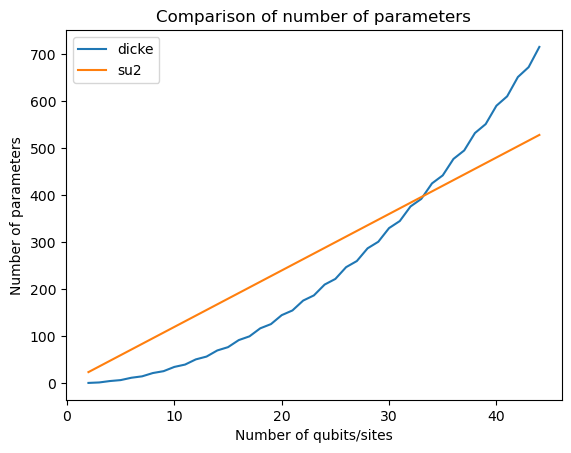

In [20]:
#Comparison of paramters 
param_dicke = []
param_su2 = []
max = 45
for n in range(2,max) : 
    k = n//2
    dicke = int(k*(n-k) + k*(k-1)/2)
    param_dicke.append(dicke)
    param_su2.append(4*n*3)   
plt.plot(range(2,max),param_dicke, label='dicke')
plt.plot(range(2,max),param_su2, label='su2')
plt.xlabel('Number of qubits/sites')
plt.ylabel('Number of parameters')
plt.title('Comparison of number of parameters')
plt.legend()